In [1]:
include("F:/Tue/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
#remember to change the path to BayesianUtilities.jl
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities
using DataStructures: Queue, enqueue!, dequeue!
using JLD, CSV, DataFrames

In [2]:
"""
The covid data is collected by RIVM from 1/6/2020 to 13/6/2021. It records the number of positive case each day in Brabant-Noord province. 
The data contains 378 observations. 
The number of positive case is store in the column "Tested_positive"
"""
## Import the Covid data
data = CSV.read("F:\\Tue\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";"); #feel free to change the directory

In [4]:
"""
Split the data into training set and test set. 
300 observations for training, 78 for testing.
"""
training_data = data.Tested_positive[1:300]; #get 300 observations from the data
training_data = reshape(training_data,30,10); # convert to a 30x10 matrix; each column is a sample containing 30 observations

test_data = data.Tested_positive[301:end]; #get 78 observations from the data
test_data = reshape(test_data,39,2); #convert to a 39x2 matrix; each column contains 39 observations

39×2 Array{Int64,2}:
 230  338
 310  309
 343  335
 293  286
 282  294
 235  307
 290  286
 236  244
 290  207
 381  216
 365  212
 369  257
 338  227
   ⋮  
 373  115
 364  102
 397   85
 403   73
 428   82
 408   34
 416   73
 359   81
 330   53
 344   45
 381   49
 379   30

### Plot a sample of observations

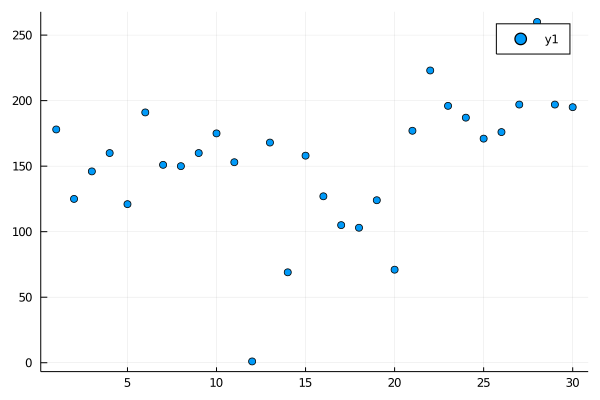

In [21]:
observation = training_data[:,9]; # pick a column from the training_data matrix. You can change from 1 to 10
T = length(observation)
scatter(observation)

## Model specification

In [22]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),100*diagm(0=>ones(2)))
p_W = Wishart(2,diagm(0=>ones(2)))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

## Inference

In [23]:
# initialize recognition factors for r and W so that q_z can be updated
q_W = p_W
;

In [24]:
# CVI message towards z
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    optimizer = ConvexAdam(η, 6) # initialize optimizer as convex combination Adam
    violation = 0 # keep track of number of updates lead to invalid parameters 
    λ_m_latest = Queue{Vector}()
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        λ_m_old = λ_m # to check the convergence
        λ_m = opt_step!(optimizer, λ_m, grad) # update message parameters
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
            enqueue!(λ_m_latest, λ_m_old)
            if n>9
                λ_m_average = sum(λ for λ in λ_m_latest)./10
                if norm(λ_m.-λ_m_average) < 0.001
                    println("Converged in step ",n)
                    break
                end
                dequeue!(λ_m_latest);
            end
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [25]:
function filter(qW, T)
    W = mean(qW)
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.4,5000)   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m))
    for t=2:T
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))))
        λ_m = approx_message_z(observation[t],predict,0.4,5000)
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m))
    end
    return forward_estimates
end

function smooth(forward_estimates, qW, T)
    W = mean(qW)
    smooth_estimates = Array{MvNormal}(undef, T)
    smooth_estimates[T] = forward_estimates[T]
    joint_dists = Array{MvNormal}(undef, T-1)
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W)
    end
    return smooth_estimates, joint_dists
end
;

In [26]:
n_its = 5
FE = zeros(n_its+1)
# Variational updates
for i=1:n_its
    # Update q(z_{1:T})
    forward_estimates = filter(q_W,T)
    smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
    
    # Calculate Free Energy before q_W and q_r updates. FE_0
    if i==1
        F = -entropy(q_W) - entropy(smooth_estimates[1])
        F += cross_entropy(q_W,p_W) + cross_entropy(smooth_estimates[1], p_z_init)
        for t=1:T-1
            F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
            F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
            Av_t = 0
            for s=1:100
                Av_t -= log_likelihood(observation[t],rand(smooth_estimates[t]))
            end
            F += Av_t/100
        end
        Av_T = 0
        for s=1:100
            Av_T -= log_likelihood(observation[T],rand(smooth_estimates[T]))
        end
        F += Av_T/100
        FE[1] = F
    end
    
    # Update qW
    q_W = p_W
    for t=1:T-1
        message = transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,nothing)
        q_W = collide(q_W,message,canonical=true)
    end
    q_W = exp_family(q_W)
    
    # Calculate Free Energy
    F = -entropy(q_W) - entropy(smooth_estimates[1])
    F += cross_entropy(q_W,p_W) + cross_entropy(smooth_estimates[1], p_z_init)
    for t=1:T-1
        F -= normal_conditional_entropy(smooth_estimates[t], smooth_estimates[t+1], joint_dists[t])
        F += transit(smooth_estimates[t],smooth_estimates[t+1],joint_dists[t],A,q_W)
        Av_t = 0
        for s=1:100
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates[t]))
        end
        F += Av_t/100
    end
    Av_T = 0
    for s=1:100
        Av_T -= log_likelihood(observation[T],rand(smooth_estimates[T]))
    end
    F += Av_T/100
    FE[i+1] = F
end

Converged in step 752
Converged in step 11
Converged in step 728
Converged in step 703
Converged in step 11
Converged in step 440
Converged in step 721


In [27]:
inv(mean(q_W))

2×2 Array{Float64,2}:
 0.15145    0.0445579
 0.0445579  0.144476

In [28]:
forward_estimates = filter(q_W,T)
smooth_estimates, joint_dists = smooth(forward_estimates, q_W, T)
;

Converged in step 424


In [29]:
FE

6-element Array{Float64,1}:
 5527.979211254054
 5503.57027409458
 5796.000639177286
 5554.444069411069
 5556.285485357334
 5497.925953390598

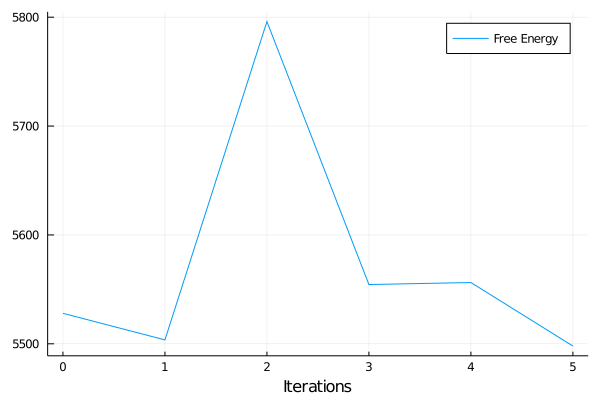

In [30]:
plot(collect(0:1:n_its),FE, label="Free Energy")
xlabel!("Iterations")

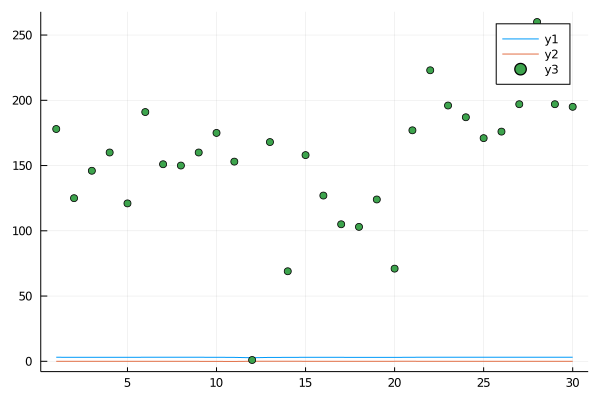

In [31]:
state1_est = zeros(T)
state2_est = zeros(T)

for t=1:T
    state1_est[t] = mean(smooth_estimates[t])[1]
    state2_est[t] = mean(smooth_estimates[t])[2]
end

plot(state1_est)
plot!(state2_est)
scatter!(observation)